# Exploratory Data Analysis

## Imports

In [1]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

import torch
import torchaudio as ta
from IPython.display import Audio

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from spacy.lang import de, en
from string import punctuation
from wordcloud import WordCloud

from data_utils import SpeechDataset, filter_yt_df, yt_data_to_df
from eval_utils import _normalize_text, _wer

## Data Initialization

In [2]:
video_dir = r"D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024_STT"
if not os.path.exists(video_dir):
    print('Video directory not found')
    raise FileNotFoundError(video_dir)
    
cache_dir = './cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

In [3]:
# yt_df, video_df, segment_df = yt_data_to_df(video_dir, do_load_transcripts=True)

In [4]:
YT_DF_PATH = r"D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\yt_df.parquet"
SEGMENT_DF_PATH = r"D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\segment_df.parquet"
VIDEO_DF_PATH = r"D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\video_df.parquet"

yt_df = pd.read_parquet(YT_DF_PATH)
segment_df = pd.read_parquet(SEGMENT_DF_PATH)
video_df = pd.read_parquet(VIDEO_DF_PATH)

### Sampling Rate

This calculation takes a long time due to I/O operations. The sampling rate is 44100 Hz for all videos.

In [5]:
# # Plot using Seaborn
# samplingrates = defaultdict(int)
# fails = []
# for audio_path in segment_df["segment_path"]:
#     try:
#         audio, sr = ta.load(audio_path)
#         samplingrates[sr] += 1
#     except Exception as e:
#         fails.append((audio_path, e))
    
    
# import seaborn as sns
# import matplotlib.pyplot as plt

# samplingrates_df = pd.DataFrame(list(samplingrates.items()), columns=['Sampling Rate', 'Count'])
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Sampling Rate', y='Count', data=samplingrates_df)
# plt.title('Sampling Rate Distribution')
# plt.xlabel('Sampling Rate')
# plt.ylabel('Count')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.show()

### Statistics

In [6]:
# Num Videos
num_videos = yt_df['video_id'].nunique()
print(f'Num Videos: {num_videos}')

Num Videos: 1820


In [7]:
print(f"Generated transcripts: {len(yt_df.groupby('is_generated')['video_id'].value_counts()[True])}")
print(f"Manual transcripts: {len(yt_df.groupby('is_generated')['video_id'].value_counts()[False])}")

Generated transcripts: 1040
Manual transcripts: 780


### Data Filtering


In [8]:
print(f"Original number of segments: {len(yt_df)}")
print(f'Number of german segments: {len(yt_df[yt_df.language == "de"])}')
print(f'Number of english segments: {len(yt_df[yt_df.language == "en"])}')
print(f"Number of auto generated segments: {len(yt_df[yt_df.is_generated == True])}")
print(f"Number of manual segments: {len(yt_df[yt_df.is_generated == False])}")
print(f"Total duration: {yt_df.segment_duration.sum() / 3600:.2f}h")
print(f"Total duration (manual): {yt_df[yt_df.is_generated == False].segment_duration.sum() / 3600:.2f}h")
print(f"Valid audio segments: {yt_df[yt_df.valid_audio].count().segment_id} / {len(yt_df)}")

Original number of segments: 28522
Number of german segments: 27612
Number of english segments: 178
Number of auto generated segments: 15815
Number of manual segments: 12707
Total duration: 164.70h
Total duration (manual): 75.17h
Valid audio segments: 28521 / 28522


In [9]:
min_segment_length = None
max_segment_length = 30
target_language = "de"
use_auto_generated = False
min_words = None
max_words = None
drop_columns = ["language", "is_generated", "num_segments", "segment_durations", "segment_id", "valid_audio"]


yt_df_filtered = filter_yt_df(
    yt_df,
    min_segment_length=min_segment_length,
    max_segment_length=max_segment_length,
    language=target_language,
    use_auto_generated=use_auto_generated,
    min_words=min_words,
    max_words=max_words,
)
yt_df_filtered = yt_df_filtered[yt_df_filtered.valid_audio].reset_index(drop=True)
print(f"Filtered number of segments: {len(yt_df_filtered)}")
print(f"Total duration: {yt_df_filtered.segment_duration.sum() / 3600:.2f}h")
print(f'Number of unique videos: {yt_df_filtered.video_id.nunique()}')
yt_df_filtered = yt_df_filtered.drop(columns=drop_columns)
yt_df_filtered.head(3)  

Filtered number of segments: 11839
Total duration: 68.59h
Number of unique videos: 733


video_id                                         video_path  \
0  -3sWj2tYFe4  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...   
1  -3sWj2tYFe4  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...   
2  -3sWj2tYFe4  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...   

                                     video_url  \
0  https://www.youtube.com/watch?v=-3sWj2tYFe4   
1  https://www.youtube.com/watch?v=-3sWj2tYFe4   
2  https://www.youtube.com/watch?v=-3sWj2tYFe4   

                                        segment_path  \
0  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...   
1  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...   
2  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...   

                                     transcript_path  segment_duration  \
0  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...             19.52   
1  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...             20.64   
2  D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024...             19.36   

                                          transcript  num_words  
0  der sich alles selbst erarbeitet hat, lässt ei...         56  
1  Elon Musk. Tesla, SpaceX, Twitter. Einer der d...         39  
2  und sich mit verschiedenen Jobs über Wasser hä...         52

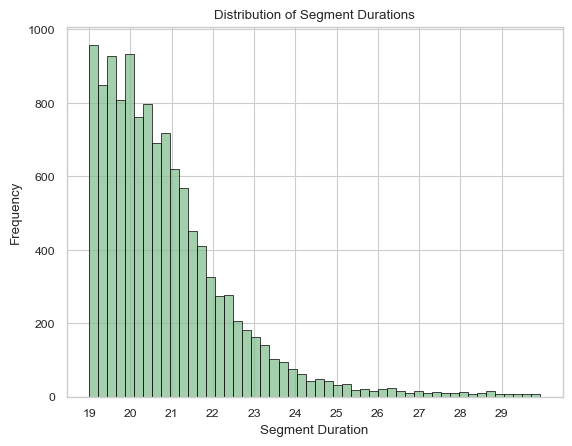

In [10]:
# Segment duration distribution

sns.set_context("paper")
sns.set_style("whitegrid")

sns.histplot(data=yt_df_filtered, x='segment_duration', bins=50, color='#86bf91', linewidth=0.5, edgecolor='black')
plt.xlabel('Segment Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Segment Durations')
plt.xticks([i for i in range(int(min(yt_df_filtered.segment_duration)), int(max(yt_df_filtered.segment_duration)) + 1, 1)])
plt.show()


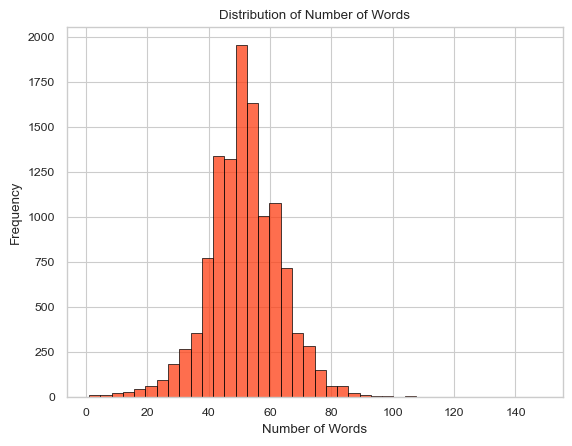

In [11]:
# Number of words distribution

sns.set_context("paper")
sns.set_style("whitegrid")

sns.histplot(data=yt_df_filtered, x='num_words', bins=40, color='#fe3e12', linewidth=0.5, edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words')
plt.show()


In [12]:
# Average words per minute
#TODO: Use tokenizer
total_words = yt_df_filtered['transcript'].apply(lambda x: len(x.split())).sum()
total_duration_minutes = yt_df_filtered['segment_duration'].sum() / 60
avg_words_per_minute = total_words / total_duration_minutes

print(f'Average words per minute: {avg_words_per_minute:.2f}s')

Average words per minute: 147.66s


### Vocabulary

In [13]:
### Generate vocabulary

import pandas as pd
import torchtext; torchtext.disable_torchtext_deprecation_warning()
from torchtext.data import get_tokenizer

# tokenizer = get_tokenizer("basic_english")

# # Function to tokenize content and update global vocabulary
# def process_transcript(transcript_path):
#     with open(transcript_path, 'r', encoding='utf-8') as file:
#         content = file.read()
#         tokens = tokenizer(content)
#     return tokens

# results = [process_transcript(row['transcript_path']) for index, row in yt_df.iterrows()]

# global_vocab = defaultdict(int)
# # Results to Vocab
# for result in results:
#     for token in result:
#         global_vocab[token] += 1
# 
# print("Global Vocabulary:")
# print(global_vocab)

In [14]:
with open('vocab.json', 'r') as f:
    global_vocab = json.load(f)

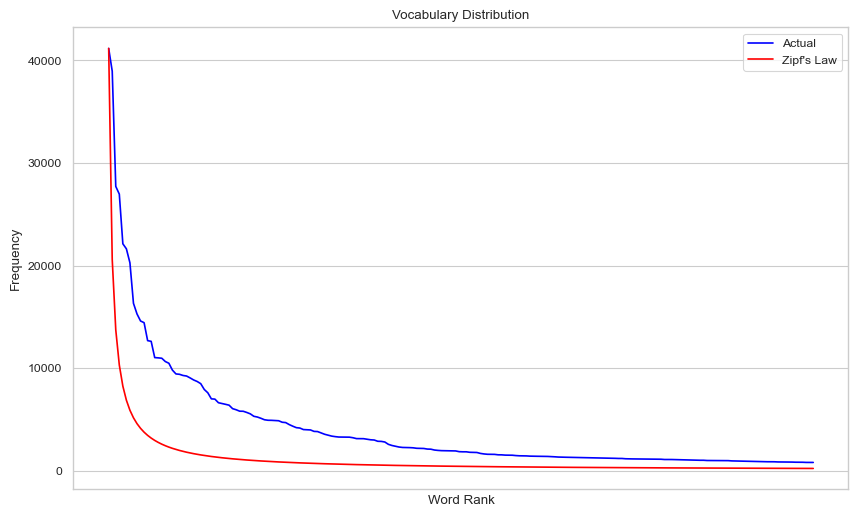

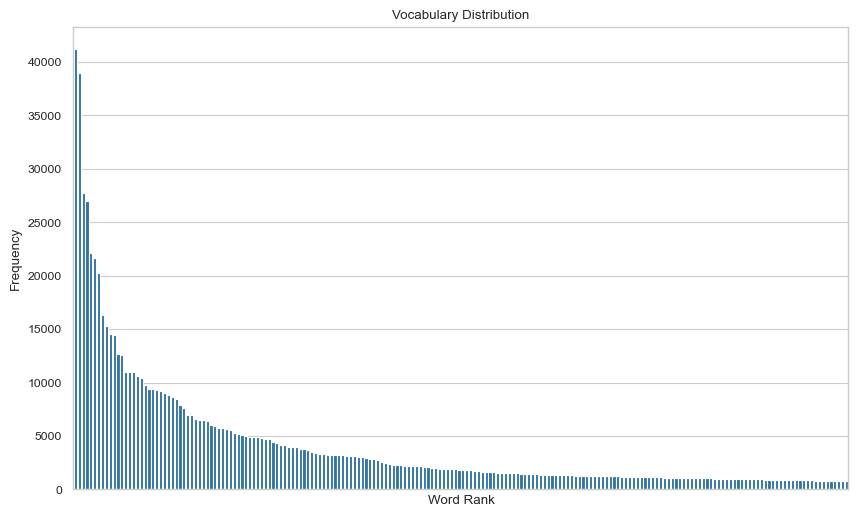

In [15]:
sorted_vocab = sorted(global_vocab.items(), key=lambda x: x[1], reverse=True) # Sort vocabulary by frequency
sorted_vocab = [(token, freq) for token, freq in sorted_vocab if token.isalnum()] # Delete punctuation tokens

tokens, frequencies = zip(*sorted_vocab)
vocab_df = pd.DataFrame({'Token': tokens, 'Frequency': frequencies}).head(200)
ranks = list(range(1, len(vocab_df) + 1))
zipf_freqs = [frequencies[0] / r for r in ranks]


plt.figure(figsize=(10, 6))
sns.lineplot(x=ranks, y=vocab_df["Frequency"], color='blue', label='Actual')
sns.lineplot(x=ranks, y=zipf_freqs, color='red', label='Zipf\'s Law')
plt.title('Vocabulary Distribution')
plt.xticks([])
plt.xlabel('Word Rank')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Token', y='Frequency', data=vocab_df)
plt.title('Vocabulary Distribution')
plt.xticks([])
plt.xlabel('Word Rank')
plt.ylabel('Frequency')
plt.show()

### Speaker and channel distribution

In [16]:
channel_dir = r"../datasynth/channel_videos"

channel_files = [os.path.join(channel_dir, f) for f in os.listdir(channel_dir)]

channel_files

vid_dict = defaultdict(str)
vids = []
for f in channel_files:    
    with open(f, 'r', encoding='utf-8') as file:
        content = file.read().split('\n')
        for vid in content:
            vids.append(vid)
            vid_dict[vid] = os.path.basename(f).split('.')[0]

channel_df = pd.DataFrame(vid_dict.items(), columns=['VID', 'Channel'])

In [17]:
num_speakers = [2,43,1,283,133,12,41,3,1,77,1,525,581,23] # Speaker diarization results

yt_df_filtered['channel'] = yt_df_filtered['video_id'].map(channel_df.set_index('VID')['Channel'])
yt_df_videos_by_channel = pd.DataFrame(yt_df_filtered.groupby('channel')['video_id'].nunique()).reset_index()
yt_df_videos_by_channel['num_speakers'] = num_speakers

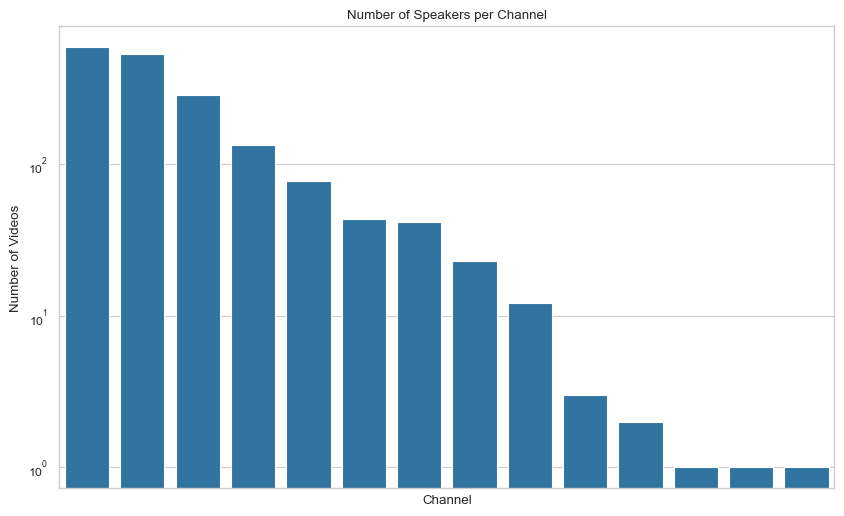

In [37]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='channel', y='num_speakers', data=yt_df_videos_by_channel, order=yt_df_videos_by_channel.sort_values('num_speakers', ascending=False).channel)
plt.title('Number of Speakers per Channel')
plt.yscale('log')
plt.xlabel('Channel')
plt.ylabel('Number of Videos')
plt.xticks([],rotation=45)
plt.show()

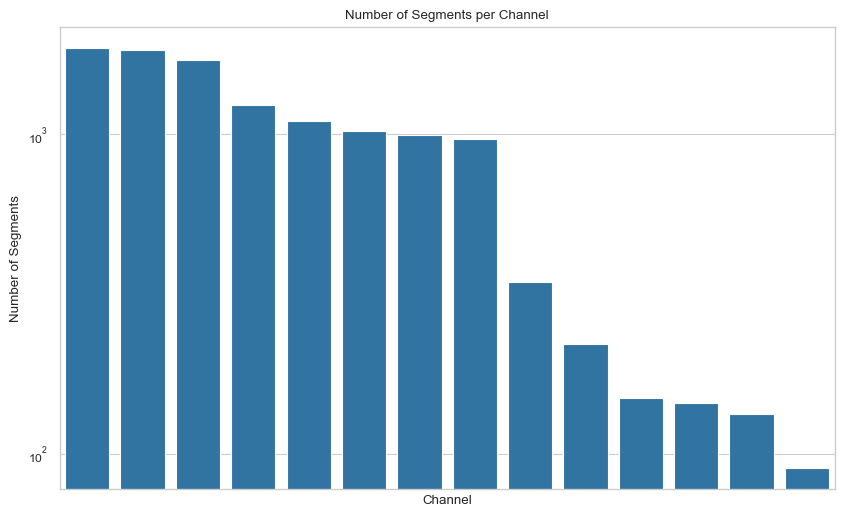

In [36]:
# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=yt_df_filtered, x='channel', order=yt_df_filtered['channel'].value_counts().index)
plt.title('Number of Segments per Channel')
plt.yscale('log')
plt.xlabel('Channel')
plt.ylabel('Number of Segments')
plt.xticks([],rotation=45)
plt.show()

### Wordcloud

In [20]:
stop_words = list(de.stop_words.STOP_WORDS) 
punctuations = list(punctuation)

clean_vocab = {k: v for k, v in global_vocab.items() if k not in stop_words and k not in punctuations}

In [21]:
print(f'{len(global_vocab)} -> {len(clean_vocab)} words')

81028 -> 80495 words


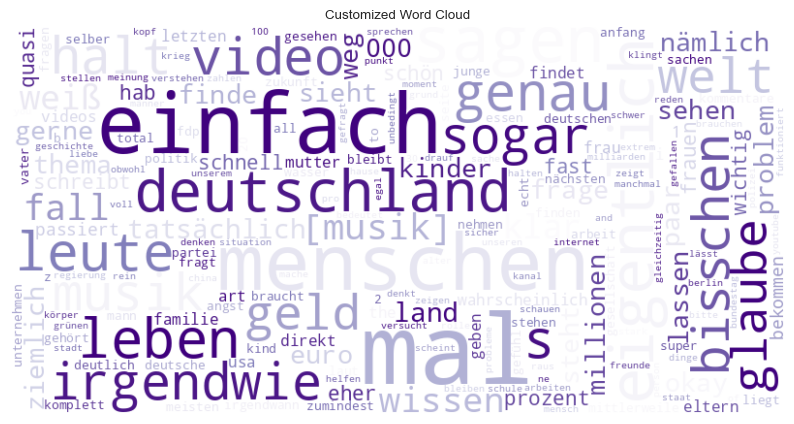

In [22]:
# Colormaps: https://matplotlib.org/stable/users/explain/colors/colormaps.html#classes-of-colormaps
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200, colormap='Purples',
                      stopwords=stop_words,
                      max_font_size=100, random_state=21).generate_from_frequencies(clean_vocab)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Customized Word Cloud')
plt.axis('off')
plt.show()


### Embeddings

In [23]:
### Generate embeddings

# from dotenv import load_dotenv

# load_dotenv("D:\workspace\s2t\deployment\.env")

# import os
# from openai import AzureOpenAI
    
# client = AzureOpenAI(
#     api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
#     api_version="2023-12-01-preview",
#     azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
# )

inputs = [k for k,v in clean_vocab.items() if v > 10]

# chunk_size = 999
# embeddings = []
# for i in range(0, len(inputs), chunk_size):
#     chunk = inputs[i:i + chunk_size]
#     embedding = client.embeddings.create(
#         input=chunk,
#         model="text-embedding-3-small",
#     )
#     embeddings.extend(embedding.data)


In [38]:
# Load embeddings
embeddings = np.load('embeddings.npy')


# --- t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
tsne_df['word'] = inputs

fig = px.scatter(tsne_df, x='x', y='y', hover_data=['word'], title='t-SNE Visualization of Word Embeddings')
fig.update_layout(
    xaxis_title='x',
    yaxis_title='y',
    width=800,
    height=800
)
fig.show()


# --- PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)
tsne_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
tsne_df['word'] = inputs

fig = px.scatter(tsne_df, x='x', y='y', hover_data=['word'], title='PCA Visualization of Word Embeddings')
fig.update_layout(
    xaxis_title='x',
    yaxis_title='y',
    width=800,
    height=800
)
fig.show()

In [30]:
# Load embeddings
embeddings = np.load('embeddings.npy')[:1000]

# --- t-SNE 3D
tsne = TSNE(n_components=3, random_state=0)
embeddings_3d = tsne.fit_transform(embeddings)

tsne_df = pd.DataFrame(embeddings_3d, columns=['x', 'y', 'z'])
tsne_df['word'] = inputs[:len(embeddings_3d)]

fig = px.scatter_3d(tsne_df, x='x', y='y', z='z', hover_data=['word'], title='t-SNE Visualization of Word Embeddings (3D)')
fig.update_traces(marker=dict(size=2)) 
fig.update_layout(scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'), 
                  width=800, height=800, autosize=False)
fig.show()


In [31]:
# Data Sample

target_sr = 16000
sample_segment = yt_df_filtered.sample(1).iloc[0]
audio_file_path = sample_segment['segment_path']
transcript = sample_segment['transcript']
wave, sr = ta.load(audio_file_path)
print(f'Loaded audio file: {audio_file_path}')
print(f'Wave shape: {wave.shape}')
print(f'Sample rate: {sr}')
display(Audio(wave.numpy(), rate=sr))

res_wave = ta.transforms.Resample(sr, target_sr)(wave)
print(f'Wave shape after resampling: {res_wave.shape}')
display(Audio(res_wave.numpy(), rate=target_sr))

# show the transcript but only x words per line
words = transcript.split()
words_per_line = 15
for i in range(0, len(words), words_per_line):
    print(' '.join(words[i:i+words_per_line]))

Loaded audio file: D:\Personal\OneDrive\Gabrilyi\SPEECH2TEXT\2024_STT\OdXHSOPhnKg\segments\segment_24.mp3
Wave shape: torch.Size([1, 861406])
Sample rate: 44100


Wave shape after resampling: torch.Size([1, 312529])


Wie sehr wünschen wir uns, jemand hätte ihr in diesem Studio mal die richtigen Fragen
gestellt. Wie fantastisch und faszinierend währen ihre Antworten wohl gewesen? Hey, hoffentlich hat euch dieses
Video gefallen.
